## Generate financial time series using diffusion models 

This contains a (not winning) solution for a [competion](https://hackathon.deepintomlf.ai/competitions/24). 

The task is describe as follows:
- Given a financial time series data with 4 variates.
- Build a model that is able to generate data close to the given data

In [1]:
from __future__ import annotations
import pickle
import equinox as eqx
from sigformer import TensorSelfAttention, TensorLayerNorm, TensorFlatten
import equinox.nn as nn
import jax.numpy as jnp
import jax
import jax.random as jrandom
import einops

from jaxtyping import Float, Array
import math
import optax
import numpy as np
import signax

import matplotlib.pyplot as plt

### How the train data looks like?

In [2]:
# train data consists of 20000 examples
with open("./time_series_generation_data/ref_data.pkl", "rb") as f:
    data = pickle.load(f)

# validation data consists of 2000 examples
with open("./time_series_generation_data/val_data.pkl", "rb") as f:
    val_data = pickle.load(f)

In [3]:
def plot_data(data, N=500):
    fig, axs = plt.subplots(2, 2)
    time = np.linspace(0, 1, 20)
    for i in range(N):
        axs[0, 0].plot(time, data[i, :, 0], linewidth=0.1)
        axs[0, 0].set_title("Price process of asset 1")
        axs[0, 0].set_xlabel("Time")
    for i in range(N):
        axs[0, 1].plot(time, data[i, :, 1], linewidth=0.1)
        axs[0, 1].set_title("Volatility process of asset 1")
        axs[0, 1].set_xlabel("Time")

    for i in range(N):
        axs[1, 0].plot(time, data[i, :, 2], linewidth=0.1)
        axs[1, 0].set_title("Price process of asset 2")
        axs[1, 0].set_xlabel("Time")

    for i in range(N):
        axs[1, 1].plot(time, data[i, :, 3], linewidth=0.1)
        axs[1, 1].set_title("Volatility process of asset 2")
        axs[1, 1].set_xlabel("Time")

    plt.tight_layout()

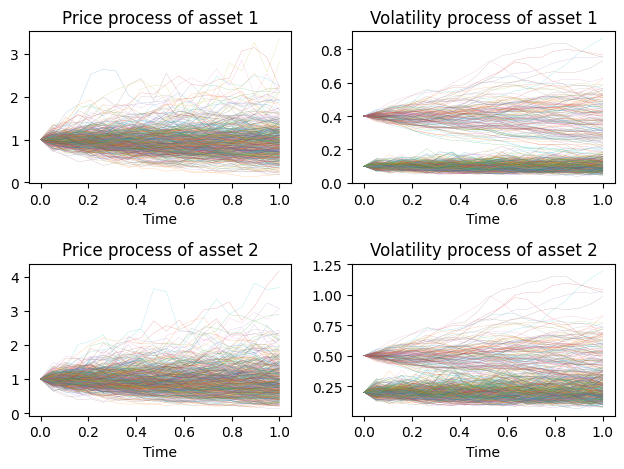

In [4]:
plot_data(data)

We can observe that volatilities are switching between two modes. The main challenge is how to deal with switch. My approach is to use **conditional** diffusion models that condition on initial value $X_0$.

### Diffusion models

In contrast with adversarial approaches that time series is generated by a generative neural network which is trained by two-player game optimization (relatively hard to train), diffusion model tries to approximate a score function in the reverse-time process.

Here, the score function is modeled by a transformer architecture - [Sigformer](https://arxiv.org/abs/2310.13369). This is another example of using Sigformer in a certain application.  

The following contains all the building blocks.

In [5]:
class LearnedSinusoidalPosEmb(eqx.Module):
    weights: jnp.ndarray

    def __init__(self, dim, *, key):
        assert dim % 2 == 0
        half_dim = dim // 2
        self.weights = jrandom.normal(key=key, shape=(half_dim,))

    def __call__(self, x: Float, *, key=None):
        """Return [x, sin(w*x), cos(w*x)]"""
        freqs = x * self.weights * 2 * math.pi
        fouriered = jnp.concatenate((jnp.sin(freqs), jnp.cos(freqs)), axis=0)
        fouriered = jnp.concatenate((x[None], fouriered), axis=0)

        return fouriered


class TimeModulatedFeedForward(eqx.Module):
    """A variant of feed forward neural network where time is introduced"""

    lin1: list[nn.Linear]
    lin2: list[nn.Linear]
    to_scale_shift: nn.Sequential

    def __init__(self, dim: int, order: int, d_ff: int, time_dim: int, *, key):
        self.to_scale_shift = nn.Sequential(
            layers=[nn.Lambda(jax.nn.silu), nn.Linear(time_dim, d_ff * 2, key=key)]
        )

        self.lin1 = []
        self.lin2 = []
        for i in range(1, order + 1):
            lin1 = nn.Linear(dim**i, d_ff, key=jrandom.fold_in(key, i * 2))
            lin2 = nn.Linear(d_ff, dim**i, key=jrandom.fold_in(key, i * 2 + 1))
            self.lin1.append(lin1)
            self.lin2.append(lin2)

    def __call__(self, x: list[Array], t_embed: Float[Array, [" time_dim"]]):
        scale_shift = self.to_scale_shift(t_embed)
        scale, shift = jnp.split(scale_shift, 2, axis=-1)

        shapes = [xx.shape for xx in x]
        x = jax.tree_util.tree_map(lambda xx: einops.rearrange(xx, "... -> (...)"), x)

        # first layer
        x = [f(xx) for f, xx in zip(self.lin1, x)]

        # use activation function
        x = jax.tree_util.tree_map(jax.nn.silu, x)

        # time modulation
        x = jax.tree_util.tree_map(lambda xx: xx * (scale + 1) + shift, x)

        # second layer
        x = [f(xx) for f, xx in zip(self.lin2, x)]
        x = jax.tree_util.tree_map(lambda xx, shape: jnp.reshape(xx, shape), x, shapes)

        return x


class Block(eqx.Module):
    attn_block: TensorSelfAttention
    attn_norm: TensorLayerNorm

    mlp_block: TimeModulatedFeedForward
    mlp_norm: TensorLayerNorm

    def __init__(self, dim, order, n_heads, time_dim, *, key):
        attn_key, mlp_key = jrandom.split(key)
        self.attn_block = TensorSelfAttention(
            order=order,
            dim=dim,
            n_heads=n_heads,
            key=attn_key,
        )
        self.attn_norm = TensorLayerNorm(dim, order)

        self.mlp_block = TimeModulatedFeedForward(
            dim, order=order, d_ff=dim * dim * 4, time_dim=time_dim, key=mlp_key
        )
        self.mlp_norm = TensorLayerNorm(dim, order)

    def __call__(
        self, x: list[Array], time_embed: Float[Array, " time_dim"], *, key=None
    ):
        resid = x
        x = self.attn_block(self.attn_norm(x), key=key)
        x = jax.tree_util.tree_map(lambda x1, x2: x1 + x2, resid, x)

        resid = x
        x = jax.vmap(lambda xx: self.mlp_block(xx, time_embed))(self.mlp_norm(x))
        x = jax.tree_util.tree_map(lambda x1, x2: x1 + x2, resid, x)

        return x


class SigFormer(eqx.Module):
    blocks: list[Block]

    def __init__(self, dim, order, n_heads, time_dim, n_layers, *, key):
        self.blocks = [
            Block(dim, order, n_heads, time_dim, key=jrandom.fold_in(key, i))
            for i in range(n_layers)
        ]

    def __call__(self, x, time_embed, *, key=None):
        for block in self.blocks:
            x = block(x, time_embed)
        return x


class ScoreFunction(eqx.Module):
    """Score function will be approximated by this class"""

    conditional: bool = eqx.static_field()
    order: int = eqx.static_field()

    project: nn.Linear
    conditional_embedding: nn.Sequential
    time_mlp: nn.Sequential
    transformer: eqx.Module
    flatten: TensorFlatten
    readout: nn.Linear

    def __init__(
        self,
        input_embed_dim: int,
        condition_embed_dim: int,
        input_dim: int = 4,
        depth: int = 4,
        order: int = 2,
        heads: int = 4,
        conditional: bool = True,
        learned_sinusoidal_dim: int = 16,
        *,
        key,
    ):
        (
            proj_key,
            time_mlp_key,
            readout_key,
            cond_emb_key,
            transformer_key,
        ) = jrandom.split(key, 5)

        self.conditional = conditional
        self.order = order
        if conditional:
            embed_dim = input_embed_dim + condition_embed_dim
        else:
            embed_dim = input_embed_dim
        self.project = nn.Linear(input_dim, input_embed_dim, key=proj_key)

        sinu_pos_emb = LearnedSinusoidalPosEmb(
            learned_sinusoidal_dim, key=jrandom.fold_in(time_mlp_key, 0)
        )
        fourier_dim = learned_sinusoidal_dim + 1
        time_dim = embed_dim * 4

        self.time_mlp = nn.Sequential(
            layers=[
                sinu_pos_emb,
                nn.Linear(fourier_dim, time_dim, key=jrandom.fold_in(time_mlp_key, 1)),
                nn.Lambda(jax.nn.gelu),
                nn.Linear(time_dim, time_dim, key=jrandom.fold_in(time_mlp_key, 2)),
            ]
        )

        self.conditional_embedding = nn.Sequential(
            layers=[
                nn.Linear(
                    input_dim, embed_dim * 2, key=jrandom.fold_in(cond_emb_key, 1)
                ),
                nn.Lambda(jax.nn.relu),
                nn.Linear(
                    embed_dim * 2,
                    condition_embed_dim,
                    key=jrandom.fold_in(cond_emb_key, 2),
                ),
            ]
        )

        self.transformer = SigFormer(
            dim=embed_dim,
            order=order,
            n_heads=heads,
            time_dim=time_dim,
            n_layers=depth,
            key=transformer_key,
        )

        self.flatten = TensorFlatten()
        readout_in_dim = sum(embed_dim ** (i + 1) for i in range(order))
        self.readout = nn.Linear(readout_in_dim, input_dim, key=readout_key)

    def __call__(
        self,
        x: Float[Array, "seq_len dim"],
        time: Float[Array, " dim_t"],
        condition: Float[Array, " dim"] = None,
    ):
        x = jax.vmap(self.project)(x)
        t = self.time_mlp(time, key=None)

        if condition is not None and self.conditional:
            cond = self.conditional_embedding(condition)
            cond = cond[None, ...]
            cond = jnp.repeat(cond, x.shape[0], axis=0)
            x = jnp.concatenate((x, cond), axis=-1)

        # compute signature
        x = jnp.pad(x, ((1, 0), (0, 0)), constant_values=0.0)
        x = signax.signature(x, depth=self.order, stream=True, flatten=False)

        x = self.transformer(x, t)

        x = self.flatten(x)
        x = jax.vmap(self.readout)(x)

        return x

### Score matching methods

The following is a typical way to train diffusion model. Actually, the code is adapted from [PyTorch code](https://github.com/lucidrains/denoising-diffusion-pytorch)

In [6]:
def logsnr_schedule_cosine(t, logsnr_min=-15, logsnr_max=15):
    t_min = math.atan(math.exp(-0.5 * logsnr_max))
    t_max = math.atan(math.exp(-0.5 * logsnr_min))
    return -0.2 * jnp.log(jnp.tan(t_min + t * (t_max - t_min)))


def right_pad_dims(x, t):
    padded_dim = x.ndim - t.ndim
    if padded_dim <= 0:
        return t
    new_shape = t.shape + (1,) * padded_dim
    return jnp.reshape(t, new_shape)


class GaussianDiffusion(eqx.Module):
    num_sample_steps: int = eqx.static_field()
    dim: int = eqx.static_field()
    min_snr_loss_weight: bool = eqx.static_field()
    min_snr_gamma: float = eqx.static_field()

    model: ScoreFunction

    def __init__(
        self,
        model,
        dim: int = 4,
        num_sample_steps=500,
        min_snr_loss_weight=True,
        min_snr_gamma=5.0,
    ):
        self.dim = dim
        self.num_sample_steps = num_sample_steps
        self.min_snr_loss_weight = min_snr_loss_weight
        self.min_snr_gamma = min_snr_gamma

        self.model = model

    def p_mean_variance(self, x, time, time_next, condition=None):
        log_snr = logsnr_schedule_cosine(time)
        log_snr_next = logsnr_schedule_cosine(time_next)
        c = -jnp.expm1(log_snr - log_snr_next)
        squared_alpha, squared_alpha_next = jax.nn.sigmoid(log_snr), jax.nn.sigmoid(
            log_snr_next
        )
        squared_sigma, squared_sigma_next = jax.nn.sigmoid(-log_snr), jax.nn.sigmoid(
            -log_snr_next
        )

        alpha, sigma, alpha_next = map(
            jnp.sqrt, (squared_alpha, squared_sigma, squared_alpha_next)
        )

        pred = self.model(x, log_snr, condition)

        x_start = (x - sigma * pred) / alpha

        model_mean = alpha_next * (x * (1 - c) / alpha + c * x_start)

        posterior_variance = squared_sigma_next * c

        return model_mean, posterior_variance

    def p_sample(self, x, time, time_next, condition=None, *, key):
        model_mean, model_variance = self.p_mean_variance(
            x=x,
            time=time,
            time_next=time_next,
            condition=condition,
        )

        noise = jrandom.normal(key=key, shape=x.shape)
        ret = jnp.where(
            time_next == 0, model_mean, model_mean + jnp.sqrt(model_variance) * noise
        )

        return ret

    def p_sample_loop(self, shape, condition=None, *, key):
        init_key, path_key = jrandom.split(key)
        x = jrandom.normal(key=init_key, shape=shape)
        steps = jnp.linspace(1.0, 0.0, self.num_sample_steps + 1)

        def scan_fn(carry, ind):
            x_, key_ = carry
            time = steps[ind]
            time_next = steps[ind + 1]
            carry = self.p_sample(
                x=x_, time=time, time_next=time_next, condition=condition, key=key_
            )

            key_ = jrandom.split(key_, 1)[0]
            return (carry, key_), None

        ret, _ = jax.lax.scan(
            scan_fn,
            (x, path_key),
            jnp.arange(self.num_sample_steps),
        )
        return ret

    def sample(
        self,
        batch_size: int,
        seq_len: int,
        x0: Float[Array, "batch_size dim"] = None,
        *,
        key,
    ):
        shape = (seq_len, self.dim)
        batch_key = jrandom.split(key, batch_size)
        ret = jax.vmap(
            lambda x_start, k: self.p_sample_loop(shape=shape, condition=x_start, key=k)
        )(x0, batch_key)
        return ret

    def q_sample(self, x_start, times, noise=None, *, key=None):
        if noise is None:
            noise = jrandom.normal(key=key, shape=x_start.shape)

        log_snr = logsnr_schedule_cosine(times)
        log_snr_padded = right_pad_dims(x_start, log_snr)
        alpha = jnp.sqrt(jax.nn.sigmoid(log_snr_padded))
        sigma = jnp.sqrt(jax.nn.sigmoid(-log_snr_padded))

        x_noise = x_start * alpha + noise * sigma

        return x_noise, log_snr

    def p_losses(self, x_start, times, condition=None, noise=None, *, key):
        if noise is None:
            noise = jrandom.normal(key=key, shape=x_start.shape)

        x, log_snr = self.q_sample(x_start, times=times, noise=noise)

        model_out = self.model(x, log_snr, condition=condition)

        target = noise

        loss = jnp.mean((model_out - target) ** 2)

        snr = jnp.exp(log_snr)

        maybe_clip_snr = jax.lax.stop_gradient(snr)

        if self.min_snr_loss_weight:
            maybe_clip_snr = jnp.clip(maybe_clip_snr, a_max=self.min_snr_gamma)

        loss_weight = maybe_clip_snr / snr

        return loss * loss_weight

    def compute_loss(
        self,
        x: Float[Array, "seq_len dim"],
        condition: Float[Array, " dim"] = None,
        *,
        key,
    ):
        time_key, loss_key = jrandom.split(key)
        times = jrandom.uniform(key=time_key, shape=(1,)).squeeze()
        return self.p_losses(x, times, condition=condition, key=loss_key)

### Some evaluation function

Here only shows three main criteria to evaluate: Covariance, Correlation, Auto-Correlation.

In [7]:
def acf(x, max_lag, axis=(0, 1)):
    acfs = []
    x = x - jnp.mean(x, axis=(0, 1))
    std = jnp.var(x, axis=(0, 1))
    for i in range(max_lag):
        y = x[:, i:] * x[:, :-i] if i > 0 else x**2
        acf_i = jnp.mean(y, axis=axis) / std
        acfs.append(acf_i)

    if axis == (0, 1):
        return jnp.stack(acfs)

    return jnp.concatenate(acfs, 1)


def acf_nonstationary(x, symmetric=False):
    b, t, d = x.shape
    correlations = jnp.zeros((t, t, d))

    for i in range(t):
        for j in range(i, t):
            correlation = jnp.sum(x[:, i, :] * x[:, j, :], axis=0)
            correlation = correlation / (
                jnp.linalg.norm(x[:, i, :], axis=0)
                * jnp.linalg.norm(x[:, j, :], axis=0)
            )
            correlations = correlations.at[i, j, :].set(correlation)
            if symmetric:
                correlations = correlations.at[j, i, :].set(correlation)

    return correlations


def cacf(x, lags, axis=(0, 1)):
    def get_lower_triangle_indices(n):
        return [list(x) for x in jnp.tril_indices(n, n)]

    ind = get_lower_triangle_indices(x.shape[2])

    x = (x - jnp.mean(x, axis=axis, keepdims=True)) / jnp.std(
        x, axis=axis, keepdims=True
    )

    x_l = x[..., ind[0]]
    x_r = x[..., ind[1]]

    cacfs = []
    for i in range(lags):
        y = x_l[:, i:] * x_r[:, :-i] if i > 0 else x_l * x_r

        cacf_i = jnp.mean(y, (1))
        cacfs.append(cacf_i)

    ret = jnp.concatenate(cacfs, 1)
    ret = jnp.reshape(ret, (ret.shape[0], -1, len(ind[0])))

    return ret


def cov(x):
    _, L, C = x.shape
    x = jnp.reshape(x, (-1, L * C))
    return jnp.cov(x, rowvar=False)


def acf_diff(x, y):
    diff = acf_nonstationary(x) - acf_nonstationary(y)
    # diff = acf(x, max_lag=x.shape[1]) - acf(y, max_lag=y.shape[1])
    return jnp.sqrt(jnp.sum(diff**2, 0))


def cc_diff(x, y):
    diff = (
        jnp.mean(cacf(x, lags=x.shape[1]), 0)[0]
        - jnp.mean(cacf(y, lags=y.shape[1]), 0)[0]
    )
    return jnp.sum(jnp.abs(diff), 0)


def cov_diff(x, y):
    diff = cov(x) - cov(y)
    return jnp.mean(jnp.abs(diff))

### Let's put together and train

In [8]:
# data processing
data = jnp.array(data)
val_data = jnp.array(val_data)

# here we preprocess data into log(S_{t+1}/S_t)
x0 = data[:, 0]
dx = jnp.log(data[:, 1:]) - jnp.log(data[:, :-1])
mean = jnp.mean(dx, axis=0)
std = jnp.std(dx, axis=0)
normalized_dx = (dx - mean) / std

In [9]:
key = jrandom.PRNGKey(0)
model_key, train_key, data_key = jrandom.split(key, 3)

In [10]:
score_function = ScoreFunction(
    input_embed_dim=8,
    condition_embed_dim=8,
    input_dim=4,
    depth=4,
    order=2,
    heads=4,
    key=jrandom.PRNGKey(0),
)
model = GaussianDiffusion(score_function, dim=4)

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

In [11]:
def compute_loss(model, x, x0, key):
    keys = jrandom.split(key, x.shape[0])
    loss_fn = lambda x_, x0_, key_: model.compute_loss(x_, x0_, key=key_)
    loss = jax.vmap(loss_fn)(x, x0, keys)
    loss = jnp.mean(loss)
    return loss

In [12]:
@eqx.filter_jit
def make_step(model, x, x0, key, opt_state, opt_update):
    loss, grads = eqx.filter_value_and_grad(lambda m: compute_loss(m, x, x0, key))(
        model
    )
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    key = jrandom.split(key, 1)[0]
    return model, loss, opt_state, key

In [13]:
@eqx.filter_jit
def sample(model, batch_size, seq_len, x0, key):
    return model.sample(batch_size, seq_len=seq_len, x0=x0, key=key)

In [14]:
batch_size = 200

for iter in range(200):
    indices = jrandom.permutation(
        key=jrandom.fold_in(data_key, iter), x=jnp.arange(data.shape[0])
    )
    current = 0

    total_loss = 0.0
    while current < data.shape[0] - batch_size:
        batch_indices = indices[current : current + batch_size]
        x0_batch = x0[batch_indices]
        x_batch = normalized_dx[batch_indices]
        model, loss, opt_state, train_key = make_step(
            model,
            x_batch,
            x0_batch,
            train_key,
            opt_state,
            optimizer.update,
        )
        total_loss += loss.item()
        current += batch_size

    # evaluation
    if (iter + 1) % 10 == 0:
        print(f"Iter {iter} \t Loss: {total_loss:.4f}")
        # this is how we get x0. Basically, this is from train data. There should be better way to do it
        # in fact, my submission is screwed because of not generating x0 correctly
        x0_fake = x0[:2000]
        x_fake = sample(
            model, batch_size=2000, seq_len=19, x0=x0_fake, key=jrandom.PRNGKey(0)
        )
        # reverse transform: rescale + cumsum + exp
        x_fake = x_fake[0] * std + mean
        x_fake = jnp.concatenate([jnp.log(x0_fake[:, None, :]), x_fake], axis=1)
        x_fake = jnp.exp(jnp.cumsum(x_fake, 1))

        acf_value = jnp.mean(acf_diff(x_fake, val_data))
        cacf_value = jnp.mean(cc_diff(x_fake, val_data))
        cov_value = jnp.mean(cov_diff(x_fake, val_data))
        print(
            f"ACF: {acf_value.item():.5f} \t Correlation: {cacf_value.item():.5f} \t Covariance: {cov_value.item():.5f}"
        )

Iter 9 	 Loss: 33.5771
ACF: 0.02413 	 Correlation: 1.41276 	 Covariance: 0.00646
Iter 19 	 Loss: 33.4101
ACF: 0.02203 	 Correlation: 0.55864 	 Covariance: 0.00628
Iter 29 	 Loss: 33.1996
ACF: 0.01790 	 Correlation: 0.68865 	 Covariance: 0.00590
Iter 39 	 Loss: 33.2859
ACF: 0.01306 	 Correlation: 0.48157 	 Covariance: 0.00526
Iter 49 	 Loss: 33.2346
ACF: 0.01849 	 Correlation: 1.35360 	 Covariance: 0.00915
Iter 59 	 Loss: 33.1821
ACF: 0.02231 	 Correlation: 1.50229 	 Covariance: 0.01134
Iter 69 	 Loss: 33.1057
ACF: 0.02020 	 Correlation: 0.91319 	 Covariance: 0.00670
Iter 79 	 Loss: 33.1707
ACF: 0.02038 	 Correlation: 0.75822 	 Covariance: 0.00651
Iter 89 	 Loss: 33.1409
ACF: 0.01652 	 Correlation: 0.66544 	 Covariance: 0.00583
Iter 99 	 Loss: 33.1019
ACF: 0.01655 	 Correlation: 0.71553 	 Covariance: 0.00511
Iter 109 	 Loss: 33.1312
ACF: 0.01821 	 Correlation: 1.03891 	 Covariance: 0.00665
Iter 119 	 Loss: 33.0055
ACF: 0.01920 	 Correlation: 0.70419 	 Covariance: 0.00612
Iter 129 	 Loss

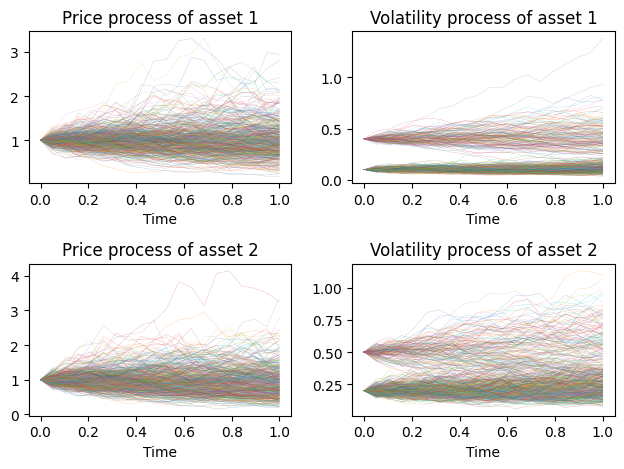

In [15]:
plot_data(x_fake)

It looks not so bad and it seems like the model converges quite early!!!